### Baltimore City Police Emergency and Non-Emergency 911 Calls for Service, 2015-2018

This notebook will analyze Baltimore's 911 police calls for service data, which can be obtained from [Open Baltimore](https://data.baltimorecity.gov/Public-Safety/911-Police-Calls-for-Service/xviu-ezkt). The calls dates range from January 1st, 2015 to present. There are 3.6 million rows as of July 1st, 2018, each row representing an individual call. Data is automatically refreshed multiple times a day.

Baltimore, MD is known for its violent crime rate, including annual robbery and homicide rates that rank above the national average. Although overall reported crime has dropped significantly since the early 1990s, homicide rates remain high and especially concentrated in poverty areas. Despite the population of Baltimore metropolitan area having shrunk over decades, its per-capita homicide record remain one of the highest in the country.

Violent crime spiked in 2015 after the death of Freddie Gray on April 19, leading to a sudden spike in civil unrest and rioting from late April to early May. Crime rates in Baltimore reached one of the highest peaks that year; 2015's tally of 344 homicides, nearly 90 percent of which were the result of shooting, was the most since 1993.


The data contains the following fields:


* recordId: Int variable, record identifier
* callDateTime: Floating timestamp, YYYY-MM-DD HH:MM:SS
* priority: String variable, priority of call
* district: String variable, quadrant of Baltimore	
* description: String variable, description of the emergency call
* callNumber: String variable, call identifier
* incidentLocation: String variable, location of incident 	
* location: String variable, location of call

### Imports & data preview

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import re
from string import punctuation
from datetime import datetime, timedelta
import folium
from folium import plugins

%matplotlib inline

In [13]:
calls = pd.read_json('https://data.baltimorecity.gov/resource/m8g9-abgb.json?$limit=5000000')
calls.head()

,calldatetime,callnumber,description,district,incidentlocation,location,location_address,location_city,location_state,priority,recordid
0,2018-02-05T11:29:00.000,P180361209,INVEST,CD,0 CHARLES PZ,NaN,0 CHARLES,PZ BALTIMORE,MD,Low,3213567
1,2017-09-25T06:07:00.000,P172680397,PRKG COMPLAINT,SD,E100,NaN,NaN,NaN,NaN,Non-Emergency,2874965
2,2018-06-04T14:02:00.000,P181551495,ARMED PERSON,WD,N PAYSON ST/PENROSE AV,NaN,N PAYSON ST,BALTIMORE,MD,High,3529597
3,2018-06-04T14:11:00.000,P181551516,DISORDERLY,SD,2000 E MCCOMAS ST,"{'type': 'Point', 'coordinates': [-76.58958, 3...",2000 E MCCOMAS ST,BALTIMORE,MD,Medium,3529620
4,2018-06-04T14:08:00.000,P181551501,NARCOTICS ONVIEW,CD,200 N EUTAW ST,"{'type': 'Point', 'coordinates': [-76.621111, ...",200 N EUTAW ST,BALTIMORE,MD,Medium,3529624


### Feature selection and data cleaning

In [14]:
"""Extracts call date, hour, and day from callDateTime"""
calls['timeStamp'] = pd.to_datetime(calls['calldatetime'])
calls['callDate'] = calls['timeStamp'].dt.date
calls['Hour'] = calls['timeStamp'].apply(lambda x: x.hour)
calls['Day'] = calls['timeStamp'].dt.strftime('%A')
calls.head()

,calldatetime,callnumber,description,district,incidentlocation,location,location_address,location_city,location_state,priority,recordid,timeStamp,callDate,Hour,Day
0,2018-02-05T11:29:00.000,P180361209,INVEST,CD,0 CHARLES PZ,NaN,0 CHARLES,PZ BALTIMORE,MD,Low,3213567,2018-02-05 11:29:00,2018-02-05,11,Monday
1,2017-09-25T06:07:00.000,P172680397,PRKG COMPLAINT,SD,E100,NaN,NaN,NaN,NaN,Non-Emergency,2874965,2017-09-25 06:07:00,2017-09-25,6,Monday
2,2018-06-04T14:02:00.000,P181551495,ARMED PERSON,WD,N PAYSON ST/PENROSE AV,NaN,N PAYSON ST,BALTIMORE,MD,High,3529597,2018-06-04 14:02:00,2018-06-04,14,Monday
3,2018-06-04T14:11:00.000,P181551516,DISORDERLY,SD,2000 E MCCOMAS ST,"{'type': 'Point', 'coordinates': [-76.58958, 3...",2000 E MCCOMAS ST,BALTIMORE,MD,Medium,3529620,2018-06-04 14:11:00,2018-06-04,14,Monday
4,2018-06-04T14:08:00.000,P181551501,NARCOTICS ONVIEW,CD,200 N EUTAW ST,"{'type': 'Point', 'coordinates': [-76.621111, ...",200 N EUTAW ST,BALTIMORE,MD,Medium,3529624,2018-06-04 14:08:00,2018-06-04,14,Monday


In [15]:
def long_lat(loc):
    """Extracts longitude and latitude from the locations column"""
    lat = None
    long = None
    
    if loc:
        try:
            loc = loc['coordinates']
            lat = loc[1]
            long = loc[0] 
        except:
            pass 
    else:
        return 
    return pd.Series([lat, long], index=['lat', 'long'])

calls[['lat', 'long']] = calls['location'][:].apply(long_lat)

calls.head()

,calldatetime,callnumber,description,district,incidentlocation,location,location_address,location_city,location_state,priority,recordid,timeStamp,callDate,Hour,Day,lat,long
0,2018-02-05T11:29:00.000,P180361209,INVEST,CD,0 CHARLES PZ,NaN,0 CHARLES,PZ BALTIMORE,MD,Low,3213567,2018-02-05 11:29:00,2018-02-05,11,Monday,NaN,NaN
1,2017-09-25T06:07:00.000,P172680397,PRKG COMPLAINT,SD,E100,NaN,NaN,NaN,NaN,Non-Emergency,2874965,2017-09-25 06:07:00,2017-09-25,6,Monday,NaN,NaN
2,2018-06-04T14:02:00.000,P181551495,ARMED PERSON,WD,N PAYSON ST/PENROSE AV,NaN,N PAYSON ST,BALTIMORE,MD,High,3529597,2018-06-04 14:02:00,2018-06-04,14,Monday,NaN,NaN
3,2018-06-04T14:11:00.000,P181551516,DISORDERLY,SD,2000 E MCCOMAS ST,"{'type': 'Point', 'coordinates': [-76.58958, 3...",2000 E MCCOMAS ST,BALTIMORE,MD,Medium,3529620,2018-06-04 14:11:00,2018-06-04,14,Monday,39.264612,-76.589580
4,2018-06-04T14:08:00.000,P181551501,NARCOTICS ONVIEW,CD,200 N EUTAW ST,"{'type': 'Point', 'coordinates': [-76.621111, ...",200 N EUTAW ST,BALTIMORE,MD,Medium,3529624,2018-06-04 14:08:00,2018-06-04,14,Monday,39.292098,-76.621111


In [16]:
# turn each call description in 'description' column into title case
calls['description'] = calls.description.str.title()

In [32]:
# delete rows containing '911/No Voice' description, where a specific reason was not cited
calls = calls[calls.description.str.contains('911') == False]

In [35]:
calls.to_pickle('C:/Users/sonye/PythonPrograms/baltimore_911_calls')

### Data Visualization

In [25]:
calls = pd.read_pickle('C:/Users/sonye/PythonPrograms/baltimore_911_calls')

In [37]:
# group call counts by each day starting from 2015-01-01
call_count = calls.groupby('callDate').count()['recordid']

# convert index type from base object index to DatetimeIndex
call_count.index = pd.to_datetime(call_count.index)

By grouping the individual calls each date, we can visualize the number of calls by each day. The chart below shows how many 911 calls Baltimore Police received each day, starting from the earliest day of record (2015-01-01). 

Each year is separated by a dotted line to show a pattern of calls by year. The incoming calls typically hit a peak in June/July and decrease until January/February

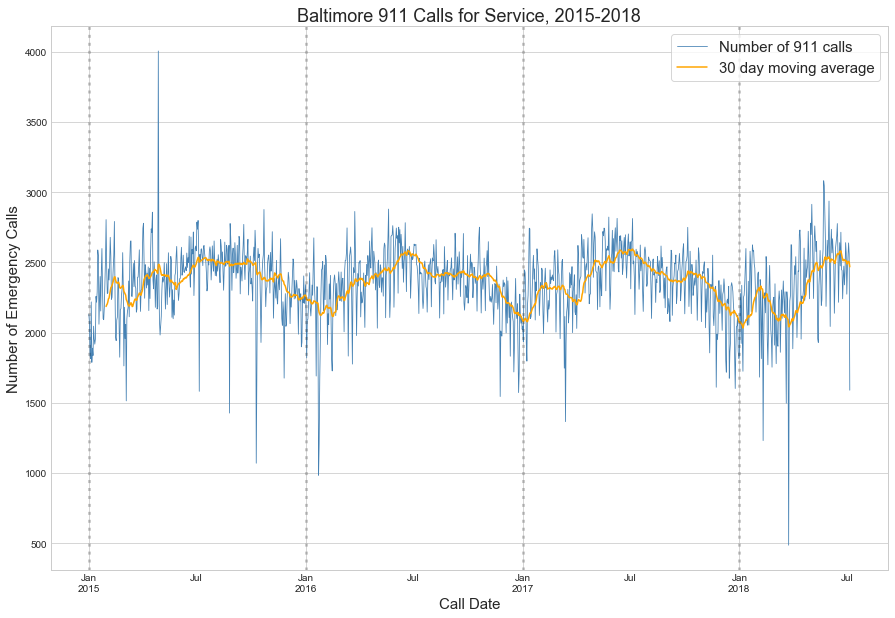

In [38]:
calls_for_service, ax = plt.subplots()

# graph countplot of number of calls each day
c = call_count.plot(figsize=(15,10), label = 'Number of 911 calls', linewidth=0.8, color='steelblue')

# graph rolling average for every thirty days
c = call_count.rolling(window=30).mean().plot(figsize=(15,10), label = '30 day moving average', color='orange')

def yearly_mark(start_year, end_year):
    """Separates each year in graph with vertical line"""
    for i in range(start_year, end_year+1):
        date = str(i)+'-01-01'
        plt.axvline(date, color='black', linewidth=3, linestyle=':', alpha=0.2)
    
yearly_mark(2015, 2018)

plt.legend(prop={'size': 15}, loc=1, frameon=True)
plt.title('Baltimore 911 Calls for Service, 2015-2018', fontsize=18)
ax.set_xlabel("Call Date", fontsize=15)
ax.set_ylabel("Number of Emergency Calls", fontsize=15)
plt.show()

calls_for_service.savefig('C:/Users/sonye/PythonPrograms/project-notebooks/all-graphs/1_calls_for_service_2015-2018.png', dpi = 400, bbox_inches = 'tight')

There is a spike in 911 calls around April/May of 2015. If we zoom into this part of the graph by limiting the x-axis to just 2015 calls, we see that this happens on April 27th, 2015. This was the date of Freddie Gray's funeral, which was followed by a sharp increase in civil disorder in Baltimore.

Baltimore in May 2015 saw 43 cases of reported homicide, making it the city's deadliest month in more than 40 years. The number of homicides fell the following month, but in July 2015 45 murders were recorded, tying with the record in 1972. For reference, Baltimore's population in the 1970's were approximately 45% higher than in 2015.

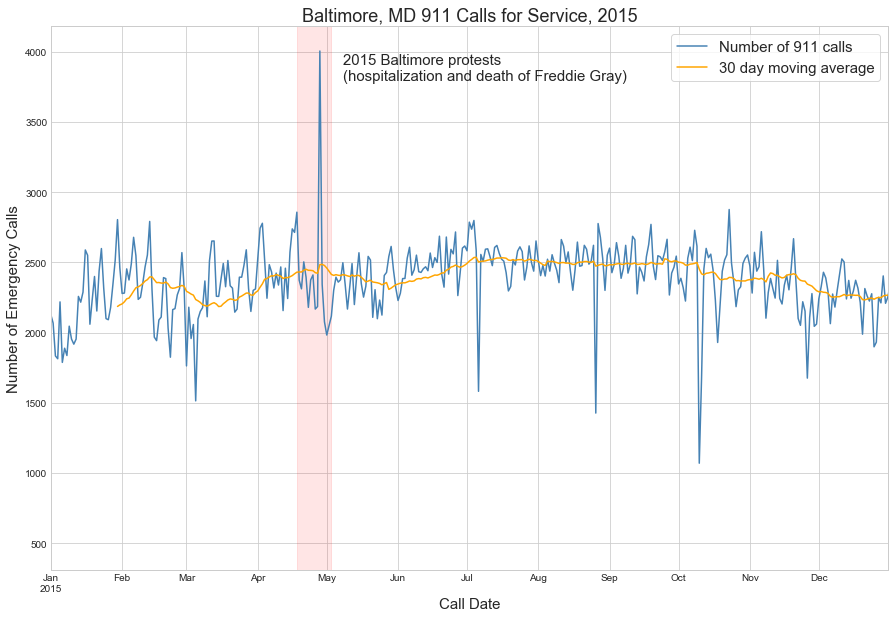

In [39]:
calls_for_service_2015, ax = plt.subplots()

# to isolate year 2015, set range starting from 2015-01-01 to 2015-12-31
startdate = datetime.strptime('2015-01-01', "%Y-%m-%d").date()
enddate = datetime.strptime('2015-12-31', "%Y-%m-%d").date()

# graph number of calls per day
call_count.plot(figsize=(15,10),label = 'Number of 911 calls', color='steelblue')
call_count.rolling(window=30).mean().plot(figsize=(15,10), label = '30 day moving average', color='orange')

# limit x axis to 2015 only
plt.xlim([startdate,enddate])

# label and mark spike in 911 call
plt.axvspan('2015-04-18', '2015-05-03', alpha=0.1, color='r')
plt.text('2015-05-08', 3800, '2015 Baltimore protests\n(hospitalization and death of Freddie Gray)', fontsize=15)

plt.legend(prop={'size': 15}, frameon=True)
plt.title('Baltimore, MD 911 Calls for Service, 2015', fontsize=18)
ax.set_xlabel("Call Date", fontsize=15)
ax.set_ylabel("Number of Emergency Calls", fontsize=15)
plt.show()

calls_for_service_2015.savefig('C:/Users/sonye/PythonPrograms/project-notebooks/all-graphs/2_calls_for_service_2015.png', dpi = 400, bbox_inches = 'tight')

By creating a pivot table of calls by date and year, we can look at how the calls in a particular date compared to point in time for other years. I have used rolling averages instead of actual calls to make it easier to compare year-by-year. We can see that although cases of homicide saw one of the highest peaks in 2015, the overall number of calls for that time of year was actually below average.

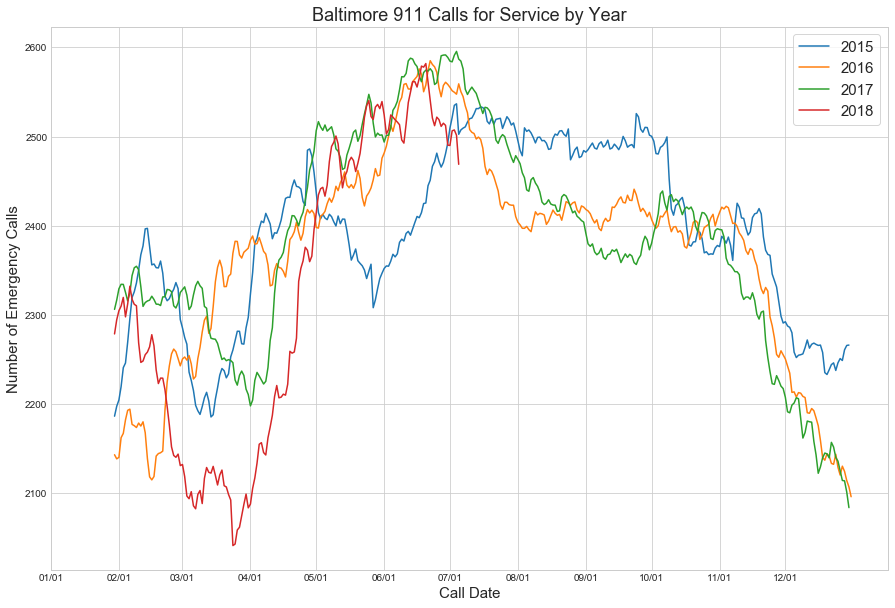

In [40]:
# create a pivot table with CallDate as index and year as columns
df = call_count.to_frame('value')
df = df.pivot_table(index=df.index.dayofyear, columns=df.index.year, values='value')

# plot monthly rolling averages for number of calls by each year
ax = df.rolling(window=30).mean().plot(figsize=(15,10))

# reformat x-axis ticks with date without year
dates = pd.date_range('20000101', '20001231', freq='MS')  # chose leap year 2000 to match days in index
ax.set_xticks(dates.dayofyear)
ax.set_xticklabels(dates.strftime('%m/%d'))

plt.legend(prop={'size': 15}, loc=1, frameon=True)
plt.title('Baltimore 911 Calls for Service by Year', fontsize=18)
ax.set_xlabel("Call Date", fontsize=15)
ax.set_ylabel("Number of Emergency Calls", fontsize=15)
#plt.show()

plt.savefig('C:/Users/sonye/PythonPrograms/project-notebooks/all-graphs/3_calls_for_service_by_year.png', dpi = 400, bbox_inches = 'tight')

Here are the top 5 most common reasons for 911 call service. We will disregard the top reason '911/NO VOICE', since we are only interested in categorized reasons for the call. We will also exclude routine non-emergency traffic stops.

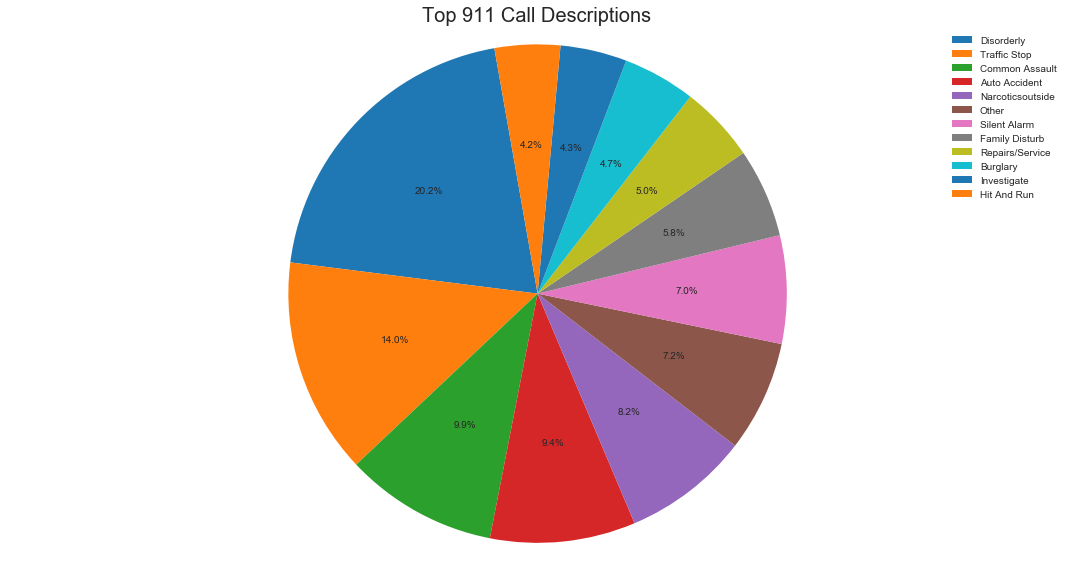

In [217]:
def PieChart(data, title):
    data['Size'] = data / data.sum() * 100
    
    fig1, ax1 = plt.subplots(figsize=(15,8))
    ax1.pie(data['Size'], autopct='%1.1f%%', startangle=100)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.legend(data.index, loc="upper right")
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.show()
    
grouped = calls.groupby('description').count()
grouped.sort_values('priority', ascending=False, inplace=True)
PieChart(grouped[grouped.priority>50000][['priority']]\
         .reset_index()\
         .set_index('description')['priority'],'Top 911 Call Descriptions')

plt.savefig('C:/Users/sonye/PythonPrograms/project-notebooks/all-graphs/4_top_descriptions_piechart.png', dpi = 400, bbox_inches = 'tight')

In [9]:
calls['description'].value_counts(ascending=False).head(12)

Disorderly          327352
Traffic Stop        226621
Common Assault      161775
Auto Accident       152376
Narcoticsoutside    132555
Other               116198
Silent Alarm        113387
Family Disturb       93500
Repairs/Service      80054
Burglary             77275
Investigate          69673
Hit And Run          68712
Name: description, dtype: int64

We'll look at the frequency of top non-traffic-related calls: Disorderly Conduct, Common Assault, and Narcotics.

The number of calls related to disorderly conduct is almost as the common assault and narcotics calls combined. They follow a similar trend of the overall calls, where we are seeing a peak in July and decrease until January. In particular, disorderly conduct calls see a sudden peak in July 4th every year.  

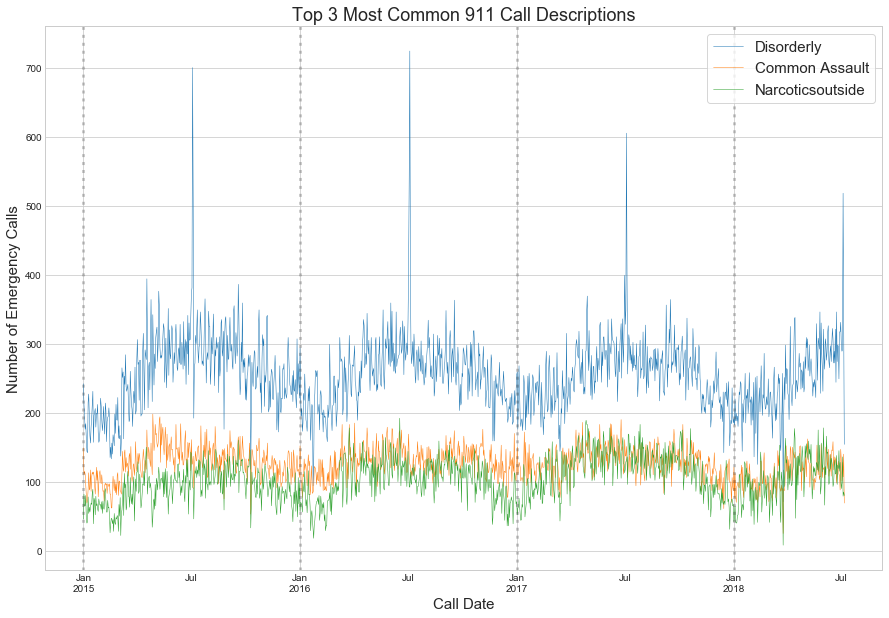

In [46]:
top_calls_for_service, ax = plt.subplots()

def top_calls(description):
    call_description = calls[calls['description'] == description].groupby('callDate').count()['recordid']
    call_description.index = pd.to_datetime(call_description.index)
    call_description.plot(figsize=(15,10), label = description.title(), linewidth=0.5)
    
top_calls('Disorderly')    
top_calls('Common Assault')
top_calls('Narcoticsoutside')

plt.legend(prop={'size': 15}, frameon=True)
plt.title('Top 3 Most Common 911 Call Descriptions', fontsize=18)
ax.set_xlabel("Call Date", fontsize=15)
ax.set_ylabel("Number of Emergency Calls", fontsize=15)

yearly_mark(2015, 2018)

top_calls_for_service.savefig('C:/Users/sonye/PythonPrograms/project-notebooks/all-graphs/5_top_calls_for_service.png', dpi = 400, bbox_inches = 'tight')

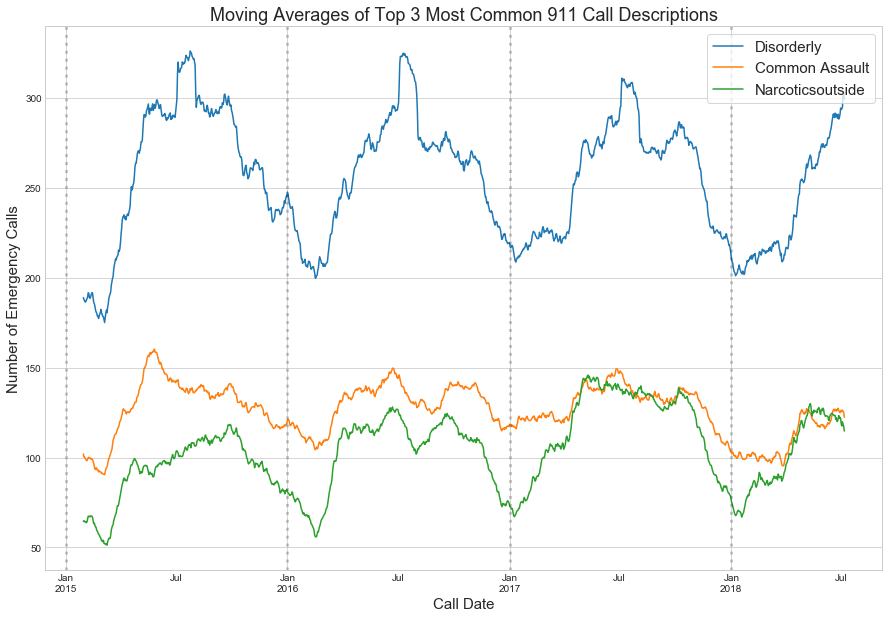

In [63]:
top_calls_for_service_average, ax = plt.subplots()

def top_calls_rolling(description):
    call_description = calls[calls['description'] == description].groupby('callDate').count()['recordid']
    call_description.index = pd.to_datetime(call_description.index)
    call_description.rolling(window=30).mean().plot(figsize=(15,10), label = description.title())
    
top_calls_rolling('Disorderly')    
top_calls_rolling('Common Assault')
top_calls_rolling('Narcoticsoutside')

plt.legend(prop={'size': 15}, frameon=True, loc='upper right')
plt.title('Moving Averages of Top 3 Most Common 911 Call Descriptions', fontsize=18)
ax.set_xlabel("Call Date", fontsize=15)
ax.set_ylabel("Number of Emergency Calls", fontsize=15)

yearly_mark(2015, 2018)

top_calls_for_service_average.savefig('C:/Users/sonye/PythonPrograms/project-notebooks/all-graphs/6_top_calls_for_service_average.png', dpi = 400, bbox_inches = 'tight')

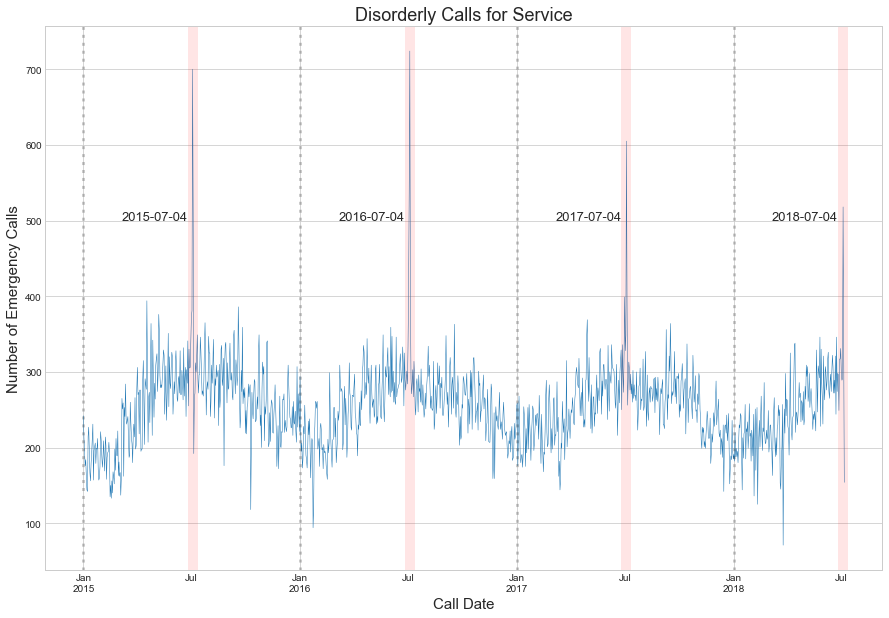

In [61]:
disorderly_calls_for_service, ax = plt.subplots()

#call_disorderly.plot(figsize=(15,10), label = 'Disorderly Calls', linewidth=0.5,)
#call_disorderly.rolling(window=30).mean().plot(figsize=(15,10), label = '30 day moving average')

top_calls('Disorderly')    

def july_4th(start_year, end_year):
    """Marks and labels dates with spike in disorderly calls"""
    for i in range(start_year, end_year+1):
        date = str(i)+'-07-04'
        plt.axvline(date, color='r', linewidth=10, alpha=0.1)
        date_1 = datetime.strptime(date, "%Y-%m-%d")
        plt.text(date_1 + timedelta(days=-120), 500, date, fontsize=13)
    
july_4th(2015, 2018)

yearly_mark(2015, 2018)

plt.title('Disorderly Calls for Service', fontsize=18)
ax.set_xlabel("Call Date", fontsize=15)
ax.set_ylabel("Number of Emergency Calls", fontsize=15)

disorderly_calls_for_service.savefig('C:/Users/sonye/PythonPrograms/project-notebooks/all-graphs/7_disorderly_calls_for_service.png', dpi = 400, bbox_inches = 'tight')

### Heatmaps and locations

So far, we look at the frequency of calls by date of the year. Let's look at these numbers using other parameters, such as location and time of day. The below heatmap shows number of calls by day of week and hour of the day. We can see that most of the calls are concentrated on weekday afternoons between 3pm to 8pm.  

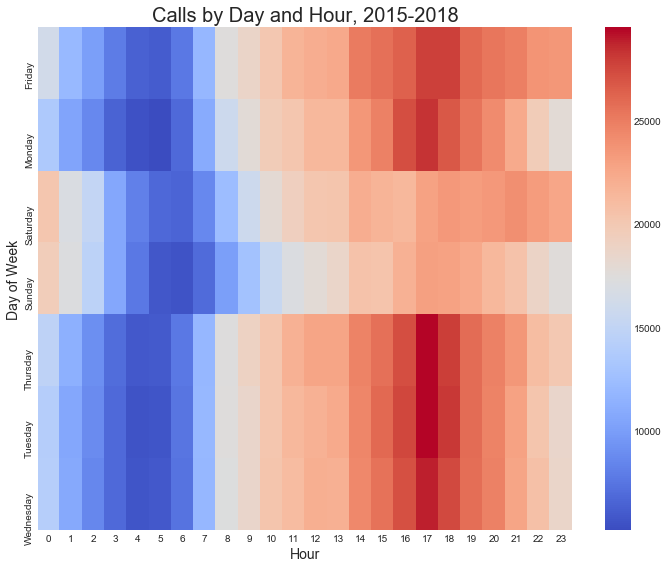

In [4]:
# group number of calls by day and hour (row and column respectively)
calls_dayHour = calls.groupby(by=['Day', 'Hour']).count()['recordid'].unstack()

# heatmap of call frequency by day of the week and hour
plt.figure(figsize=(10,8))
calls_dayHour_heatmap = sns.heatmap(calls_dayHour, cmap='coolwarm')
plt.title('Calls by Day and Hour, 2015-2018', fontsize=20)
plt.xlabel('Hour',fontsize=14)
plt.ylabel('Day of Week',fontsize=14)

plt.tight_layout()

plt.savefig('C:/Users/sonye/PythonPrograms/project-notebooks/all-graphs/8_calls_dayHour_heatmap.png', dpi = 400, bbox_inches = 'tight')

Below is a similar view but exclusively looking at the most common call description: disorderly conduct. The patterns are similar to the overall call pattern, but we see that more calls are concentrated in late weekend nights.

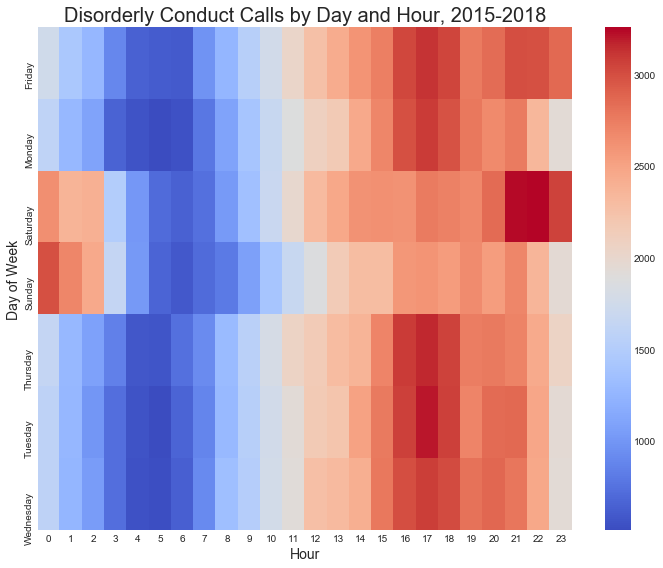

In [173]:
# limit calls to top three most common descriptions not related to auto accidents
calls_disorderly = calls.loc[calls.description.isin(['Disorderly'])]

# group number of disorderly conduct cals by day and hour
calls_disorderly_dayHour = calls_disorderly.groupby(by=['Day', 'Hour']).count()['recordid'].unstack()

plt.figure(figsize=(10,8))
calls_disorderly_dayHour_heatmap = sns.heatmap(calls_disorderly_dayHour, cmap='coolwarm')
plt.title('Disorderly Conduct Calls by Day and Hour, 2015-2018', fontsize=20)
plt.xlabel('Hour',fontsize=14)
plt.ylabel('Day of Week',fontsize=14)

plt.tight_layout()

plt.savefig('C:/Users/sonye/PythonPrograms/project-notebooks/all-graphs/9_calls_disorderly_dayHour_heatmap.png', dpi = 400, bbox_inches = 'tight')

In [28]:
# limit the dataframe to nine police districts in Baltimore
calls_district = calls.loc[calls.district.isin(['NE', 'SE', 'SD', 'SW', 'CD', 'ND', 'NW', 'WD', 'ED'])]

# disable chained assignments
pd.options.mode.chained_assignment = None 

# convert abbreviated district names to stretch out
calls_district['district'] = calls_district['district'].map({'NE': 'Northeastern',
                                                             'SE': 'Southeastern',
                                                             'SD': 'Southern',
                                                             'SW': 'Southwestern',
                                                             'CD': 'Central',
                                                             'ND': 'Northern',
                                                             'NW': 'Northwestern',
                                                             'WD': 'Western',
                                                             'ED': 'Eastern'})

# save calls_district
calls_district.to_pickle('C:/Users/sonye/PythonPrograms/baltimore_911_calls_district')

In [7]:
calls_district = pd.read_pickle('C:/Users/sonye/PythonPrograms/baltimore_911_calls_district')

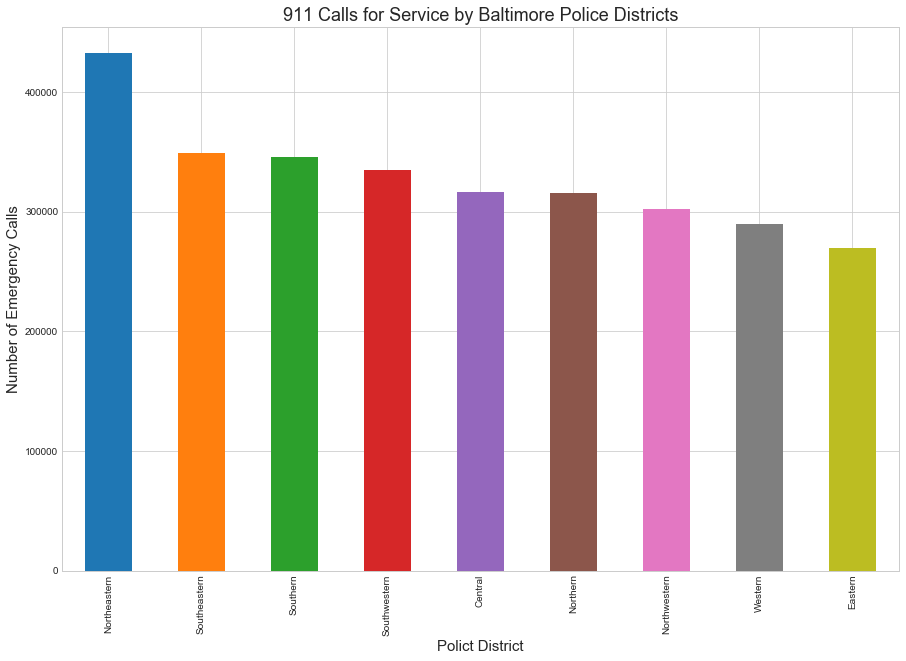

In [29]:
# group number of calls by police district
calls_district_groupby = calls_district.groupby('district').count()['recordid'].sort_values(ascending=False)

ax = calls_district_groupby.plot.bar(figsize=(15,10))
plt.title('911 Calls for Service by Baltimore Police Districts', fontsize=18)
ax.set_xlabel("Polict District", fontsize=15)
ax.set_ylabel("Number of Emergency Calls", fontsize=15)

plt.savefig('C:/Users/sonye/PythonPrograms/project-notebooks/all-graphs/10_calls_district_groupby.png', dpi = 400, bbox_inches = 'tight')

In [252]:
calls_district_top3 = calls_district.loc[calls_district.description.isin(['Disorderly', 'Common Assault', 'Narcoticsoutside'])]
calls_district_top3_groupby = calls_district_top3.groupby(['district', 'description']).size()
calls_district_top3_groupby

district      description     
Central       Common Assault      18382
              Disorderly          45689
              Narcoticsoutside    11511
Eastern       Common Assault      15417
              Disorderly          28367
              Narcoticsoutside    14136
Northeastern  Common Assault      22944
              Disorderly          41501
              Narcoticsoutside     8179
Northern      Common Assault      15751
              Disorderly          37289
              Narcoticsoutside     7623
Northwestern  Common Assault      16380
              Disorderly          35860
              Narcoticsoutside    19718
Southeastern  Common Assault      16700
              Disorderly          38361
              Narcoticsoutside     8539
Southern      Common Assault      21197
              Disorderly          39774
              Narcoticsoutside    18457
Southwestern  Common Assault      18605
              Disorderly          33092
              Narcoticsoutside    17372
Western  

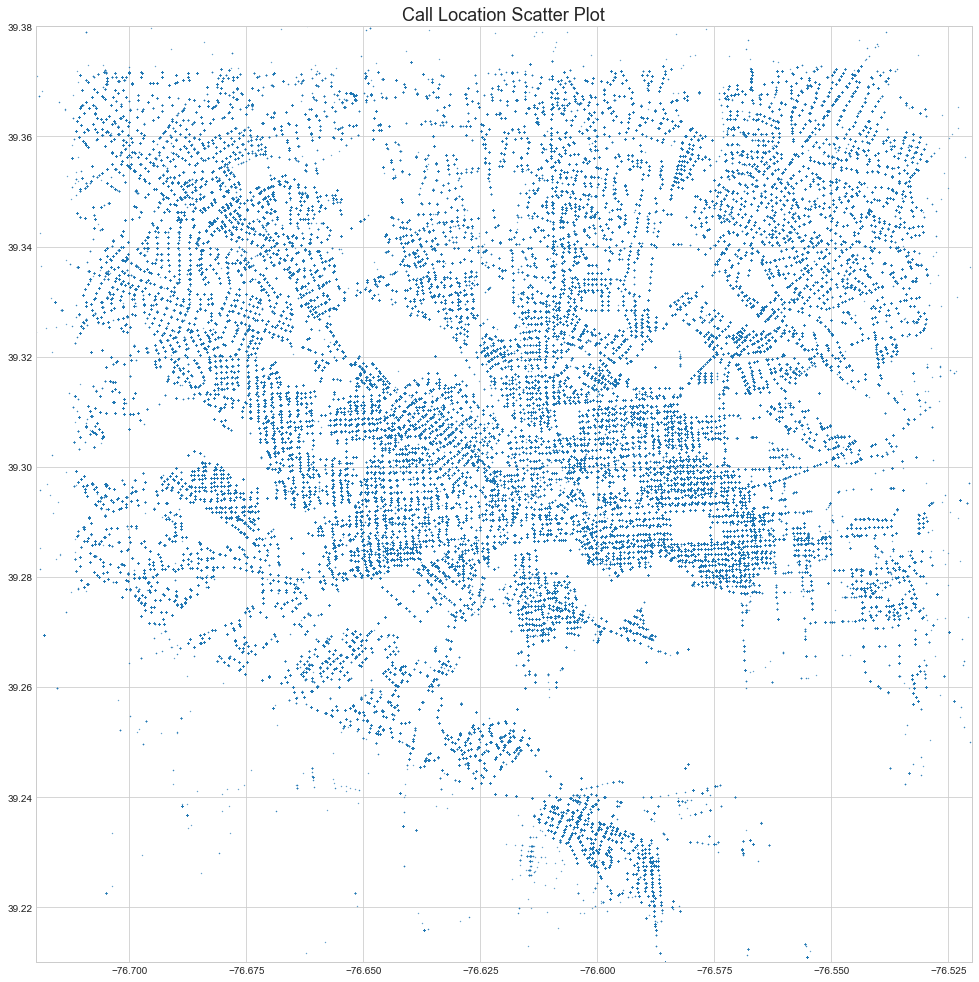

In [196]:
fig = plt.figure(figsize=(13,13))
ax = fig.add_axes([0,0,1,1])


ax.scatter(y=calls["lat"], x=calls["long"], s=0.1)

plt.title('Call Location Scatter Plot', fontsize=18)
ax.set_xlim(-76.52, -76.72)
ax.set_ylim(39.21, 39.38)
ax.invert_xaxis()

plt.savefig('C:/Users/sonye/PythonPrograms/project-notebooks/all-graphs/11_baltimore_scatter.png', bbox_inches = 'tight')

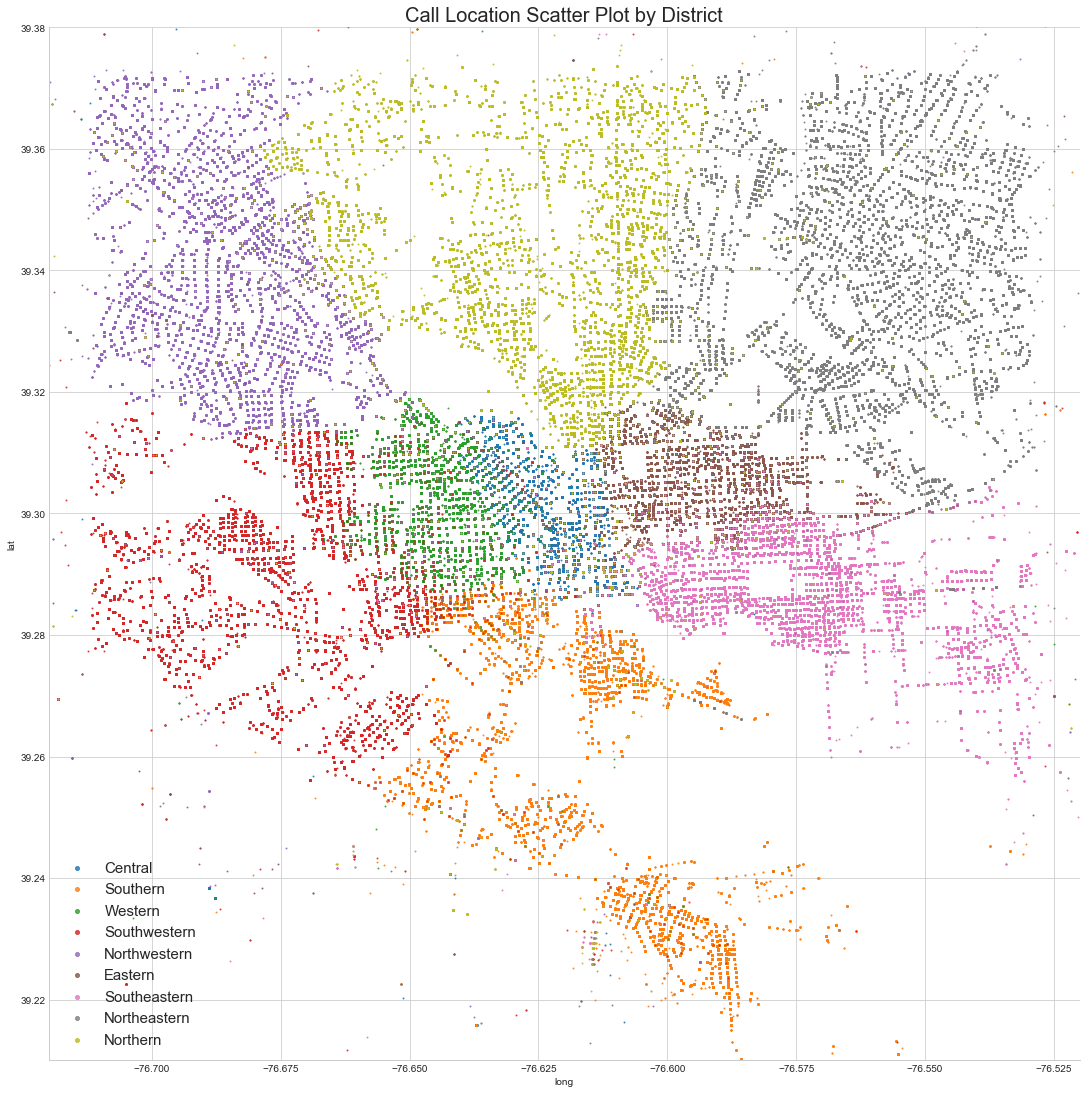

In [37]:
lm = sns.lmplot( x="long", y="lat", data=calls_district, hue='district', 
                fit_reg=False, legend=True, legend_out=False, 
                scatter_kws={"s": 1}, size=15)

plt.title('Call Location Scatter Plot by District', fontsize=20)
plt.legend(prop={'size': 15}, loc = 3, markerscale=4)
plt.ylim(39.21, 39.38)
plt.xlim(-76.52, -76.72)
plt.gca().invert_xaxis()

plt.savefig('C:/Users/sonye/PythonPrograms/project-notebooks/all-graphs/12_baltimore_scatter_district.png', bbox_inches = 'tight')

#### Use the following [nbviewer](https://nbviewer.jupyter.org/github/ymericson/example-notebook/blob/master/Baltimore%20911%20Calls.ipynb) link to view the below JavaScript content 

In [178]:
# map Baltimore using central latitude and longitude
baltLatLong = [39.299236, -76.609383]
baltMap = folium.Map(baltLatLong, zoom_start=12)

# convert lat and long from calls in a list-in-list format for heatmap
calls_latLong_list = calls[['lat', 'long']].dropna()[:50000].values.tolist()

# plot heatmap
baltMap.add_child(plugins.HeatMap(calls_latLong_list, radius=10))
baltMap

### Model data for Machine Learning regression

1. The location is given as latitude/longitude coordinates, so we can select a long and lat as features. 
2. Convert district location to numeric form to use as feature. Numbers correspond to 9 areas in a plane. For example, Northwestern is 1, North is 2, Northeastern is 3, and so on.
3. Date/Time can be deconstructed further. 
 - The year the crime occurred can be extracted without special encoding. (2015 — 2018). This is a helpful feature in predictive models to help understand the change over time
 - Extract the month in a similar manner (12 values, from 1 — 12)
 - Extract the day of the month when the call occured (31 values, from 1 - 31)
 - We already have the hour in which a given call occurred as a feature (hour can take 24 different values from 0 — 23)
 - We already have the day of the week (Monday - Sunday), but we want them in number form (7 values, 0 - 6 with 0 being Monday)

In [8]:
# copy from dataframe that has nine districts
calls_feat = calls_district[['district', 'timeStamp', 'Hour', 'lat', 'long']].copy()

# extract features from the 'timeStamp' value
calls_feat['year'] = calls_feat['timeStamp'].dt.year
calls_feat['month'] = calls_feat['timeStamp'].dt.month
calls_feat['dayNum'] = calls_feat['timeStamp'].dt.day
calls_feat['dayOfWeek'] = calls_feat['timeStamp'].dt.dayofweek

# convert districts to integers based on location on a 9-plane area
calls_feat['district'] = calls_feat['district'].map({'Northwestern': 1,
                                                   'Northern': 2,
                                                   'Northeastern': 3,
                                                   'Western': 4,
                                                   'Central': 5,
                                                   'Eastern': 6,
                                                   'Southwestern': 7,
                                                   'Southern': 8,
                                                   'Southeastern': 9})

# re-order columns
calls_feat = calls_feat[['year', 'month', 'dayNum', 'dayOfWeek', 'Hour',
                         'district', 'lat', 'long']]

calls_feat.head(10)

,year,month,dayNum,dayOfWeek,Hour,district,lat,long
0,2018,2,5,0,11,5,NaN,NaN
1,2017,9,25,0,6,8,NaN,NaN
2,2018,6,4,0,14,4,NaN,NaN
3,2018,6,4,0,14,8,39.264612,-76.589580
4,2018,6,4,0,14,5,39.292098,-76.621111
7,2018,2,5,0,12,7,39.290746,-76.605649
8,2018,2,5,0,12,7,39.308923,-76.671096
9,2018,2,5,0,12,1,39.363705,-76.701472
10,2018,2,5,0,12,7,NaN,NaN
11,2018,2,5,0,12,7,39.302804,-76.670522


There are a lot of missing latitude and longitude features. If we make a heatmap fo all features that are null, we can see that a chunk of the 'lat' and 'long' rows have no value.

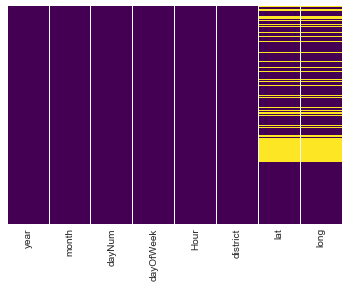

In [9]:
sns.heatmap(calls_feat.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [10]:
calls_feat.to_pickle('C:/Users/sonye/PythonPrograms/baltimore_911_calls_feat')

In [11]:
calls_feat = pd.read_pickle('C:/Users/sonye/PythonPrograms/baltimore_911_calls_feat')

In [12]:
calls_feat = calls_feat.dropna()
calls_feat.head()

,year,month,dayNum,dayOfWeek,Hour,district,lat,long
3,2018,6,4,0,14,8,39.264612,-76.589580
4,2018,6,4,0,14,5,39.292098,-76.621111
7,2018,2,5,0,12,7,39.290746,-76.605649
8,2018,2,5,0,12,7,39.308923,-76.671096
9,2018,2,5,0,12,1,39.363705,-76.701472


In [14]:
from sklearn.model_selection import train_test_split
X = calls_feat.drop('year', axis=1)
y = calls_feat['year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

<font color='blue'>Logistic Regression Model</font>

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

       2015       0.30      0.28      0.29    183274
       2016       0.32      0.14      0.20    181638
       2017       0.29      0.42      0.34    185207
       2018       0.25      0.33      0.28     96000

avg / total       0.29      0.29      0.28    646119



[[51309 24403 74526 33036]
 [49487 25743 75540 30868]
 [51265 24368 77050 32524]
 [21817  5845 36620 31718]]


<font color='blue'>Decision Tree Classifier</font>

In [91]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

       2015       0.88      0.88      0.88    183274
       2016       0.86      0.86      0.86    181638
       2017       0.87      0.87      0.87    185207
       2018       0.97      0.97      0.97     96000

avg / total       0.88      0.88      0.88    646119



[[160743  11575  10340    616]
 [ 11124 156250  13406    858]
 [ 10178  13113 160701   1215]
 [   625    811   1274  93290]]


<font color='blue'>Random Forest Classifier</font>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))